In [1]:
import torch
import torch_tensorrt
import timm
import time
import numpy as np
import torch.backends.cudnn as cudnn
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import json

resnet_model = timm.create_model('resnet18', pretrained=True)
model = resnet_model.eval().to("cuda")


/home/venom/miniconda3/envs/nebullvm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:timm.models.helpers:Loading pretrained weights from url (https://download.pytorch.org/models/resnet18-5c106cde.pth)


In [2]:
!mkdir -p ./data
!wget  -O ./data/img0.JPG "https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630"
!wget  -O ./data/img1.JPG "https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg"
!wget  -O ./data/img2.JPG "https://www.artis.nl/media/filer_public_thumbnails/filer_public/00/f1/00f1b6db-fbed-4fef-9ab0-84e944ff11f8/chimpansee_amber_r_1920x1080.jpg__1920x1080_q85_subject_location-923%2C365_subsampling-2.jpg"
!wget  -O ./data/img3.JPG "https://www.familyhandyman.com/wp-content/uploads/2018/09/How-to-Avoid-Snakes-Slithering-Up-Your-Toilet-shutterstock_780480850.jpg"

!wget  -O ./data/imagenet_class_index.json "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

--2023-02-11 09:38:44--  https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/siberian-husky-detail.jpg?bust=1535566590&width=630
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)... 18.67.153.177, 18.67.153.179, 18.67.153.148, ...
Connecting to d17fnq9dkz9hgj.cloudfront.net (d17fnq9dkz9hgj.cloudfront.net)|18.67.153.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24112 (24K) [image/jpeg]
Saving to: ‘./data/img0.JPG’

./data/img0.JPG     100%[===================>]  23.55K  --.-KB/s    in 0.004s  

2023-02-11 09:38:44 (5.16 MB/s) - ‘./data/img0.JPG’ saved [24112/24112]

--2023-02-11 09:38:44--  https://www.hakaimagazine.com/wp-content/uploads/header-gulf-birds.jpg
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.hakaimagazine.com (www.hakaimagazine.com)... 164.92.73.117
Connecting to www.hakaimagazine.com (www.hakaimagazine.com)|164.92.73.117|:443.

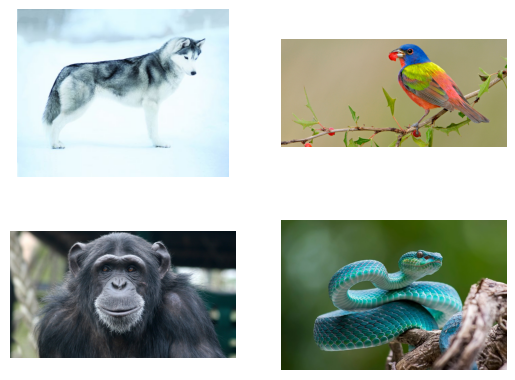

In [3]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2)

for i in range(4):
    img_path = './data/img%d.JPG' % i
    img = Image.open(img_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                             0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(img)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis('off')

# loading labels
with open("./data/imagenet_class_index.json") as json_file:
    d = json.load(json_file)


In [4]:
cudnn.benchmark = True

def efficientnet_preprocess():
    config = resolve_data_config({}, model=model)
    transform = create_transform(**config)
    return transform

# decode the results into ([predicted class, description], probability)
def predict(img_path, model):
    img = Image.open(img_path)
    preprocess = efficientnet_preprocess()
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
        # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
        sm_output = torch.nn.functional.softmax(output[0], dim=0)
        
    ind = torch.argmax(sm_output)
    return d[str(ind.item())], sm_output[ind] #([predicted class, description], probability)

def benchmark(model, input_shape=(1024, 1, 224, 224), dtype='fp32', nwarmup=50, nruns=10000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output features size:", features.size())
    print('Average throughput: %.2f images/second'%(input_shape[0]/np.mean(timings)))

./data/img0.JPG - Predicted: ['n02109961', 'Eskimo_dog'], Probablility: 0.4549652934074402
./data/img1.JPG - Predicted: ['n01828970', 'bee_eater'], Probablility: 0.5015026926994324
./data/img2.JPG - Predicted: ['n02481823', 'chimpanzee'], Probablility: 0.9965930581092834
./data/img3.JPG - Predicted: ['n01729977', 'green_snake'], Probablility: 0.21280616521835327


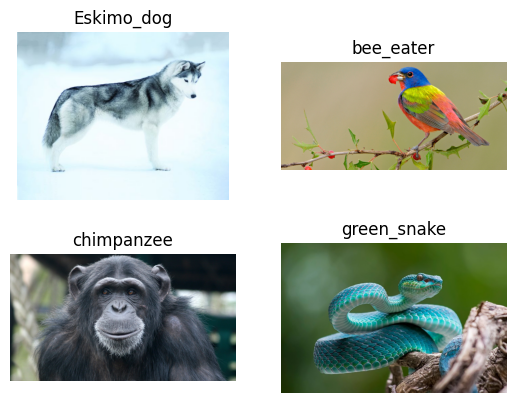

In [5]:
for i in range(4):
    img_path = './data/img%d.JPG'%i
    img = Image.open(img_path)
    
    pred, prob = predict(img_path, resnet_model)
    print('{} - Predicted: {}, Probablility: {}'.format(img_path, pred, prob))

    plt.subplot(2,2,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(pred[1])

In [6]:
benchmark(model, input_shape=(128, 3, 224, 224), nruns=100)


Warm up ...
Start timing ...
Iteration 10/100, avg batch time 68.66 ms
Iteration 20/100, avg batch time 68.56 ms
Iteration 30/100, avg batch time 68.56 ms
Iteration 40/100, avg batch time 68.55 ms
Iteration 50/100, avg batch time 68.55 ms
Iteration 60/100, avg batch time 68.54 ms
Iteration 70/100, avg batch time 68.57 ms
Iteration 80/100, avg batch time 68.60 ms
Iteration 90/100, avg batch time 68.60 ms
Iteration 100/100, avg batch time 68.63 ms
Input shape: torch.Size([128, 3, 224, 224])
Output features size: torch.Size([128, 1000])
Average throughput: 1865.07 images/second


In [7]:
trt_model_fp32 = torch_tensorrt.compile(model, inputs=[torch_tensorrt.Input((128, 3, 224, 224), dtype=torch.float32)],
                                        enabled_precisions=torch.float32,  # Run with FP32
                                        workspace_size=1 << 22
                                        )


In [ ]:
benchmark(trt_model_fp32, input_shape=(128, 3, 224, 224), nruns=100)

In [ ]:
# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP16 precision.
trt_model_fp16 = torch_tensorrt.compile(model, inputs=[torch_tensorrt.Input((128, 3, 224, 224), dtype=torch.half)],
                                        enabled_precisions={
                                            torch.half},  # Run with FP16
                                        workspace_size=1 << 22
                                        )


In [ ]:
# Obtain the average time taken by a batch of input
benchmark(trt_model_fp16, input_shape=(
    128, 3, 224, 224), dtype='fp16', nruns=100)
